# Importing Libraries and Loading Data

In [2]:
# Import the libraries
import pandas as pd
import numpy as np
import sweetviz as sv

from sklearn.ensemble import GradientBoostingRegressor

from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from flaml import AutoML

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Load the data
train = pd.read_csv('train_BRCpofr.csv')
test = pd.read_csv('test_koRSKBP.csv')
ss = pd.read_csv('sample_submission.csv')

In [5]:
pd.set_option('display.max_columns', 50)
train.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


# EDA

In [6]:
train.shape

(89392, 12)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89392 entries, 0 to 89391
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              89392 non-null  int64 
 1   gender          89392 non-null  object
 2   area            89392 non-null  object
 3   qualification   89392 non-null  object
 4   income          89392 non-null  object
 5   marital_status  89392 non-null  int64 
 6   vintage         89392 non-null  int64 
 7   claim_amount    89392 non-null  int64 
 8   num_policies    89392 non-null  object
 9   policy          89392 non-null  object
 10  type_of_policy  89392 non-null  object
 11  cltv            89392 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 8.2+ MB


In [8]:
train.isnull().sum()

id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv              0
dtype: int64

In [9]:
train.describe()

,id,marital_status,vintage,claim_amount,cltv
count,89392.00,89392.00,89392.00,89392.00,89392.00
mean,44696.50,0.58,4.60,4351.50,97952.83
std,25805.39,0.49,2.29,3262.36,90613.81
min,1.00,0.00,0.00,0.00,24828.00
25%,22348.75,0.00,3.00,2406.00,52836.00
50%,44696.50,1.00,5.00,4089.00,66396.00
75%,67044.25,1.00,6.00,6094.00,103440.00
max,89392.00,1.00,8.00,31894.00,724068.00


In [17]:
categorical_variables = train.columns[train.dtypes == 'object']
for i in categorical_variables:
    print(train[i].unique())

['Male' 'Female']
['Urban' 'Rural']
['Bachelor' 'High School' 'Others']
['5L-10L' 'More than 10L' '2L-5L' '<=2L']
['More than 1' '1']
['A' 'C' 'B']
['Platinum' 'Gold' 'Silver']


In [58]:
# More EDA with sweetviz

#eda = sv.analyze(train)
#eda.show_html('edal.html')

## Data Processsing and Feature Engineering

In [62]:
#Splitting x and y
y_train = train['cltv']

x_train = train.iloc[:,1:11]
x_test = test.iloc[:,1:11]

In [63]:
#Labelling Train and test to join them for easy analysis and to split them later for test and train seperately

x_train['data'] = 'train'
x_test['data'] = 'test'
all = pd.concat([x_train,x_test])
all.shape

(148987, 11)

In [64]:
data_col = all['data']
all.drop('data', axis=1, inplace=True)
data_col

0        train
1        train
2        train
3        train
4        train
         ...  
59590     test
59591     test
59592     test
59593     test
59594     test
Name: data, Length: 148987, dtype: object

In [65]:
# Convert times of day to numeric encoded form
all['income']=all['income'].replace({ '<=2L':1, '2L-5L':2,'5L-10L':3, 'More than 10L': 4})
all['type_of_policy'] = all['type_of_policy'].replace({'Platinum': 3, 'Gold': 2, 'Silver': 1})
all['gender'] = all['gender'].replace({'Male': 0, 'Female': 1})
all['num_policies'] = all['num_policies'].replace({'1': 0, 'More than 1': 1})
all['area'] = all['area'].replace({'Rural': 0,'Urban': 1})
all = pd.get_dummies(all)

In [66]:
# Creating new feature Claim amount with respect to income

h = all['income']
all['claim/income'] = all['claim_amount']/h

In [67]:
all.head()

,gender,area,income,marital_status,vintage,claim_amount,num_policies,type_of_policy,qualification_Bachelor,qualification_High School,qualification_Others,policy_A,policy_B,policy_C,claim/income
0,0,1,3,1,5,5790,1,3,1,0,0,1,0,0,1930.00
1,0,0,3,0,8,5080,1,3,0,1,0,1,0,0,1693.33
2,0,1,3,1,8,2599,1,3,1,0,0,1,0,0,866.33
3,1,0,3,0,7,0,1,3,0,1,0,1,0,0,0.00
4,0,1,4,1,6,3508,1,2,0,1,0,1,0,0,877.00


In [68]:
num_cols= all.columns[np.where(all.dtypes == object)[0]]
num_cols

Index([], dtype='object')

In [69]:
num_cols2= ['claim_amount', 'claim/year' ]

def remove_outliers(data,num_cols):
    for col in num_cols:
        limit = (data[col].quantile(0.75) - data[col].quantile(0.25))*1.5
        
        high = data[col].quantile(0.75) + limit
        low = data[col].quantile(0.25)- limit
        
        data[col] = np.where(
            data[col] > high,
            high,
            np.where(
                data[col] < low,
                low,
                data[col]))
    return(data)

all = remove_outliers(all,num_cols)

In [70]:
all['data'] = data_col

In [71]:
# Seperate Train, Test features
x_train = all[all['data'] == 'train'] 
x_test = all[all['data'] == 'test']
                                                                                          
x_train = x_train.drop(['data'], axis=1)
x_test = x_test.drop(['data'], axis=1)

In [72]:
x_train.isnull().sum()

gender                       0
area                         0
income                       0
marital_status               0
vintage                      0
claim_amount                 0
num_policies                 0
type_of_policy               0
qualification_Bachelor       0
qualification_High School    0
qualification_Others         0
policy_A                     0
policy_B                     0
policy_C                     0
claim/income                 0
dtype: int64

# AutoML 

In [73]:
automl_log = AutoML() 

In [74]:
automl_log.fit(x_train, y_train, task="regression",metric='r2',time_budget=60,estimator_list = ['lgbm'],
          n_splits=5)

[flaml.automl.automl: 01-22 20:57:41] {2715} INFO - task = regression
[flaml.automl.automl: 01-22 20:57:41] {2717} INFO - Data split method: uniform
[flaml.automl.automl: 01-22 20:57:41] {2720} INFO - Evaluation method: holdout
[flaml.automl.automl: 01-22 20:57:41] {2847} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 01-22 20:57:41] {2993} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.automl: 01-22 20:57:41] {3322} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 01-22 20:57:41] {3460} INFO - Estimated sufficient time budget=4425s. Estimated necessary time budget=4s.
[flaml.automl.automl: 01-22 20:57:41] {3507} INFO -  at 0.3s,	estimator lgbm's best error=0.9208,	best estimator lgbm's best error=0.9208
[flaml.automl.automl: 01-22 20:57:41] {3322} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 01-22 20:57:41] {3507} INFO -  at 0.4s,	estimator lgbm's best error=0.9208,	best estimator lgbm's best error=0.9208
[flaml.automl.auto

In [75]:
print('Best r2 on validation data: {0:.4g}'.format(1-automl_log.best_loss))

Best r2 on validation data: 0.1512


Text(0.5, 1.0, 'Feature Importance')

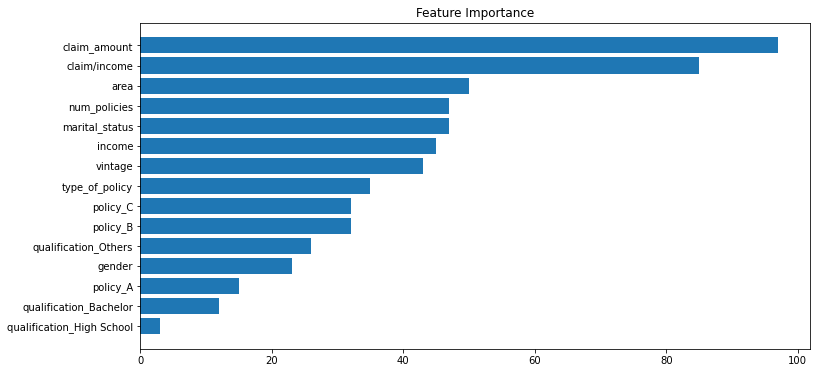

In [76]:
feature_importance = automl_log.feature_importances_
sorted_idx = np.argsort(feature_importance)[-25:]

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_train.columns)[sorted_idx])
plt.title('Feature Importance')

# Converting to CSV

In [490]:
ss['cltv'] = automl_log.predict(x_test)

In [491]:
ss.to_csv('predict.csv', index=False)

In [126]:
ss = pd.read_csv("drive/MyDrive/Competition/sample_submission.csv")

# LazyPredict

In [36]:
#This takes lot of time to run

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 26%|██▌       | 11/42 [00:26<01:42,  3.30s/it]

GaussianProcessRegressor model failed to execute
Unable to allocate 38.1 GiB for an array with shape (71513, 71513) and data type float64


 40%|████      | 17/42 [00:40<00:51,  2.06s/it]

KernelRidge model failed to execute
Unable to allocate 38.1 GiB for an array with shape (71513, 71513) and data type float64


 62%|██████▏   | 26/42 [00:50<00:33,  2.10s/it]

MLPRegressor model failed to execute
underflow encountered in true_divide


 74%|███████▍  | 31/42 [09:38<08:36, 46.97s/it] 

QuantileRegressor model failed to execute
Unable to allocate 38.1 GiB for an array with shape (71513, 71513) and data type float64


100%|██████████| 42/42 [18:59<00:00, 27.13s/it] 

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoostingRegressor                    0.16       0.16  82021.59   
HistGradientBoostingRegressor                0.16       0.16  82082.32   
LGBMRegressor                                0.16       0.16  82157.73   
PoissonRegressor                             0.16       0.16  82171.28   
LassoLars                                    0.15       0.15  82402.33   
LassoCV                                      0.15       0.15  82413.22   
Lasso                                        0.15       0.15  82415.19   
LassoLarsIC                                  0.15       0.15  82415.25   
LarsCV                                       0.15       0.15  82415.25   
Lars                                         0.15       0.15  82415.25   
LassoLarsCV                                  0.15       0.15  82415.25   
Ridge                                 

Tried XGBoost, LGBM using AutoML
Tried Lazy Predict and GradientBoostingRegressor had the highest r2_score

Uploaded both to get the results for Private Data
LGBM performed well with High accuracy